In [89]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from datetime import datetime
sys.path.append('/home/jeffreydhy/workspace/project-ares/ares-finance')
from utils.time_utils import Utility
from train.pattern_recognition.segementation_generation import SegmentImageGenerator
from collections import OrderedDict

## Generate images for prediction

This is just a demonstration step. It should have already been done offline.

In [80]:
def generate_image(dates, output_dir):
    for date in dates:
        data = pd.read_csv('~/data/projects/ares-finance/generated/bar/amd/{}_1_min.csv'.format(date), parse_dates=['timestamp'])
        segment_sizes = [30]
        seggen = SegmentImageGenerator(data)
        seggen.generate_segmented_images(segment_sizes, 'AMD', output_dir)

In [99]:
SYMBOL = 'AMD'
DATE_START = '2023-04-04'
DATE_END = '2023-04-04'
dates = Utility.list_trading_days(DATE_START, DATE_END)
output_dir = '/home/jeffreydhy/data/projects/ares-finance/generated/images/experiment'
# generate_image(dates, output_dir) - Uncomment this if you need to actually run it.

## Inference

In [100]:
# res_plotted = results[0].plot()
# plt.imshow(res_plotted)

In [104]:
def map_box_to_timestamp(startX_pixels, boxW_pixels, totalW_pixels, timestamp_start, timestamp_end):
    """
    Map the bounding box from image coordinates to the corresponding timestamp range.

    Parameters
    ----------
    startX_pixels : float
        The x-coordinate of the left edge of the bounding box (in pixels).
    boxW_pixels : float
        The width of the bounding box (in pixels).
    totalW_pixels : float
        The total width of the image (in pixels).
    timestamp_start : pd.Timestamp
        The start time of the data segment that the image was generated from.
    timestamp_end : pd.Timestamp
        The end time of the data segment that the image was generated from.

    Returns
    -------
    tuple
        A tuple of two pd.Timestamps representing the start and end time of the
        segment that corresponds to the bounding box.
    """
    # calculate the fraction of the total width that startX and boxW represent
    frac_start = startX_pixels / totalW_pixels
    frac_width = boxW_pixels / totalW_pixels

    # calculate the total duration of the segment in minutes
    total_duration = 30

    # calculate the start time and duration of the segment that corresponds to the bounding box
    segment_start_min = total_duration * frac_start
    segment_duration_min = total_duration * frac_width
    result = []

    for delta_start, delta_end in [(0, 0), (0, 1), (1, 0), (-1, 0), (0, -1), (1, 1), (-1, -1)]:
        # convert these values to timestamps
        segment_start = timestamp_start + pd.Timedelta(minutes=segment_start_min+delta_start)
        segment_end = segment_start + pd.Timedelta(minutes=segment_duration_min+delta_end)
        result.append((segment_start.round('min'), segment_end.round('min')))

    return result


image 1/1 /mnt/data/projects/ares-finance/generated/images/inference/AMD_30min_segments/20230103093000_20230103095900.png: 480x640 1 ABCD, 4.7ms
Speed: 0.9ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


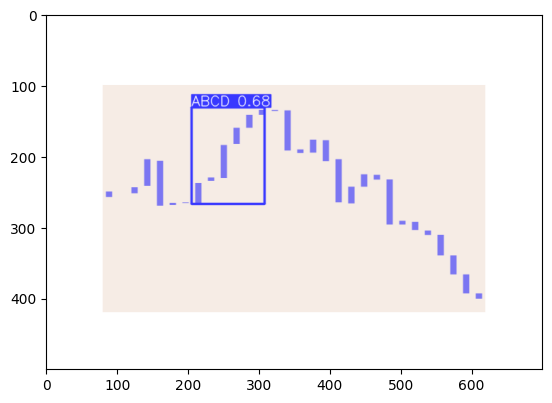

In [107]:
img_dir = '/home/jeffreydhy/data/projects/ares-finance/generated/images/inference/AMD_30min_segments/20230103093000_20230103095900.png'
pt = '/home/jeffreydhy/workspace/project-ares/ares-finance/train/models/yolov5_abcd.pt'
results = model(img_dir, conf=0.5, save=False, augment=False, device=1)
res_plotted = results[0].plot()
plt.imshow(res_plotted)
    

In [106]:
img_dir = '/home/jeffreydhy/data/projects/ares-finance/generated/images/inference/AMD_30min_segments/20230103093000_20230103095900.png'
pt = '/home/jeffreydhy/workspace/project-ares/ares-finance/train/models/yolov5_abcd.pt'
model = YOLO(pt)

results = []
for filename in os.listdir(img_dir):
    if filename.endswith(".png"):
        
        # Split the filename into start and end timestamps
        start_str, end_str = filename[:-4].split("_")  # Remove .png and split

        # Parse the strings into datetime objects
        start_timestamp = datetime.strptime(start_str, "%Y%m%d%H%M%S")
        end_timestamp = datetime.strptime(end_str, "%Y%m%d%H%M%S")
        inferences = model(os.path.join(img_dir, filename), conf=0.5, save=False, augment=False, device=1)
        
        for inference in inferences:
            # get the predictions tensor
            pred = inference.boxes.xyxy
            # for each detection in the image
            for detection in pred:
                # unpack the detection
                startX, startY, endX, endY = detection

                # Convert string to pandas Timestamp
                timestamp_start = pd.to_datetime(start_str)
                timestamp_end = pd.to_datetime(end_str)

                # The startX is already in pixels, so no need to convert
                startX_pixels = startX.item()
                boxW_pixels = (endX - startX).item()
                results += map_box_to_timestamp(startX_pixels, boxW_pixels, 640, timestamp_start, timestamp_end)

NotADirectoryError: [Errno 20] Not a directory: '/home/jeffreydhy/data/projects/ares-finance/generated/images/inference/AMD_30min_segments/20230103093000_20230103095900.png'

In [95]:
unique_results = list(OrderedDict.fromkeys(results).keys())

In [97]:
unique_results.sort()

In [98]:
print(unique_results[:10])

[(Timestamp('2023-01-03 09:39:00'), Timestamp('2023-01-03 09:42:00')), (Timestamp('2023-01-03 09:39:00'), Timestamp('2023-01-03 09:43:00')), (Timestamp('2023-01-03 09:39:00'), Timestamp('2023-01-03 09:44:00')), (Timestamp('2023-01-03 09:40:00'), Timestamp('2023-01-03 09:43:00')), (Timestamp('2023-01-03 09:40:00'), Timestamp('2023-01-03 09:44:00')), (Timestamp('2023-01-03 09:40:00'), Timestamp('2023-01-03 09:45:00')), (Timestamp('2023-01-03 09:40:00'), Timestamp('2023-01-03 09:46:00')), (Timestamp('2023-01-03 09:41:00'), Timestamp('2023-01-03 09:44:00')), (Timestamp('2023-01-03 09:41:00'), Timestamp('2023-01-03 09:45:00')), (Timestamp('2023-01-03 09:41:00'), Timestamp('2023-01-03 09:46:00'))]


Now we have a list of unique timestamp tuples that represents the start and end timestamp of ABCD pattern. Next step is to run <> algorithm to identitfy AB period of the pattern. 

In [ ]:
def find_AB_period(ABCD):
    

In [ ]:
find_AB_period(unique_results)
